In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import requests
import geopandas as gpd
import sys
import itertools
from shapely.geometry import Point

from ocf_datapipes.utils.geospatial import osgb_to_lat_lon

sys.path.append("../../../../gradboost_pv/")
from gradboost_pv.preprocessing.geospatial import (
    get_eso_uk_multipolygon,
    check_point_in_multipolygon,
    check_points_in_multipolygon_multiprocessed
)

/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/nowcasting_datamodel/models/forecast.py:196: SAWarning: This declarative base already contains a class with the same class name and module name as nowcasting_datamodel.models.forecast.ForecastValueYearMonth, and will be replaced in the string-lookup table.
  class ForecastValueYearMonth(ForecastValueSQLMixin, Base_Forecast):


Unable to import PVLive utils, please provide filenames with OpenGSP
Unable to import PVLive utils, please provide filenames with OpenGSP


In [3]:
nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
gsp_path = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
gsp = xr.open_zarr(gsp_path)
nwp = xr.open_zarr(nwp_path)

evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)

In [4]:
uk_poly = get_eso_uk_multipolygon()

/home/tom/dev/gradboost_pv/notebooks/models/geospatial_dsample/../../../../gradboost_pv/gradboost_pv/preprocessing/geospatial.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return MultiPolygon(


In [5]:
# create a coordinates matrix for the NWP variables
coords = list(map(lambda x: Point(x[0], x[1]), itertools.product(nwp.coords["x"].values, nwp.coords["y"].values)))

# create a mask for belonging to UK region or not
mat = check_points_in_multipolygon_multiprocessed(coords, uk_poly)
bool_mask = mat.reshape(len(nwp.coords["x"]), len(nwp.coords["y"])).T

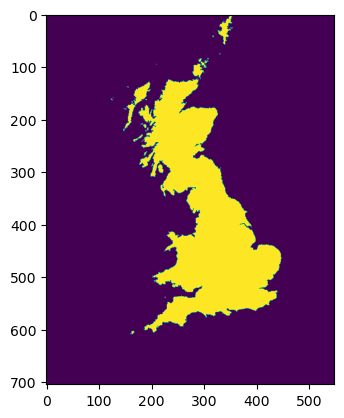

In [6]:
plt.imshow(bool_mask)

In [25]:
nwp.coords["variable"]

<xarray.DataArray 'variable' (variable: 17)>
array(['cdcb', 'lcc', 'mcc', 'hcc', 'sde', 'hcct', 'dswrf', 'dlwrf', 'h', 't',
       'r', 'dpt', 'vis', 'si10', 'wdir10', 'prmsl', 'prate'], dtype='<U6')
Coordinates:
  * variable  (variable) <U6 'cdcb' 'lcc' 'mcc' ... 'wdir10' 'prmsl' 'prate'

In [26]:
a = range(3)
b = range(5)

In [32]:
list(itertools.product(a, b))

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4)]

In [7]:
nan_mask = bool_mask.copy().astype(float)
nan_mask[nan_mask == 0] = np.nan

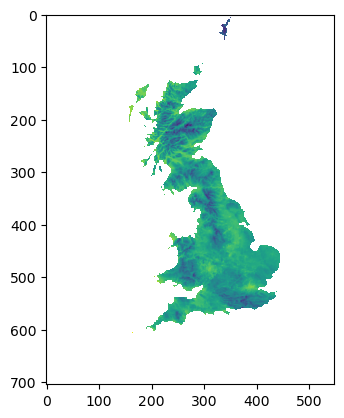

In [8]:
plt.imshow(nan_mask *  nwp.isel(init_time=30, variable=9, step=1).to_array().values.reshape(704, 548))

In [20]:
output = (nan_mask *  nwp.isel(variable=9, step=[1]).to_array()).mean(dim=["x", "y"]).as_numpy()

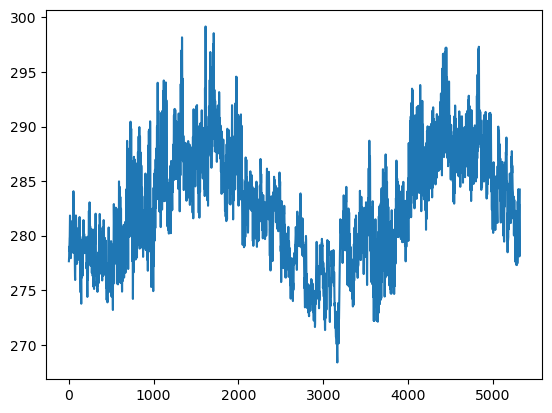

In [24]:
plt.plot(output.values.reshape(5319))

In [15]:
subset = nwp.isel(step=[1,2,5], variable=9).to_array()

In [16]:
masked = subset * nan_mask

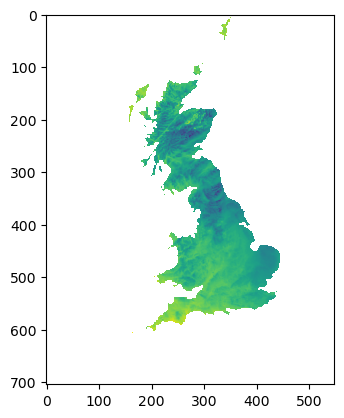

In [17]:
plt.imshow(masked.isel(init_time=4, step=2).values.reshape(704, 548))

In [2]:
masked.isel(init_time=4, step=2).values.reshape(704, 548)

NameError: name 'masked' is not defined

In [18]:
filtered_subset = nwp.isel(step=[1], variable=9).to_array() * nan_mask
values = filtered_subset.mean(dims=["x", "y"])as_numpy().values

: 

: 